# Probabilistic Data Association

This notebook is the implementation of PDA algorithm for single target tracking algorithm.
The terminology used in this file is listed as below

You are tracking the traget x in a discrete time space, at time t = k
- track: $x_k$
- observation: $z_k$, with total $m_k$ elements in time k
- accumualted observation: $Z^k = \{z_1, z_2, ..., z_k\}$

The pseudocode for PDA is the following based on [here](https://www.youtube.com/watch?v=qq6a04je9ck&list=PLadnyz93xCLiHWjLcLFdzc-SidNL1kRF7&index=18):

1. for each observation $\theta \in z_k$:

    compute $w_k^\theta$, $\hat{x}_k^\theta$, $P_k^\theta$:
    
    Term $\hat{x}_k^\theta$, $P_k^\theta$ is updated by KF, $\bar{z} = H_{k-1}\hat{x}_{k|k-1}$ and $S = S_k$ evaluted at observation $z$.
    
    $$w_k^\theta = \begin{cases}
        1 - P_D &  \text{ if } \theta = 0\\
        \frac{P_DN(z^\theta; \bar{z}, S)}{\lambda_c(\theta)} & \text{if } \theta = 1, 2, ..., m_k
    \end{cases}$$
    
   **Question**: what is this $\lambda_c(\theta)$, called intensity fuction?
   
   From the video [here](https://www.youtube.com/watch?v=iOWorq2qw4Y&list=PLadnyz93xCLiHWjLcLFdzc-SidNL1kRF7&index=12) at 4'43", the describer says its either a clutter detection or an object detection, while their example in 3'21" does not gives me a good intuition on it. WHY $\lambda_c(\theta) = 0$ when $|c| > 5$? when put this into the $w_k^\theta$ you will get infinity weight on some observation you don't want to count.
   
   **Answer**: after viewing the revelant papers, here we applied the nonparametric intensity function
    $$\lambda_c(\theta) = \begin{cases}
        1 &  \text{ if } \theta = 0\\
        \frac{m_k}{V} & \text{if } \theta = 1, 2, ..., m_k
    \end{cases}$$
    
    here V is the volume of the observation area, here we are looking into the squre of 30\*10, so I applied V = 300.
 
2. Set 
$$    
\bar{x}_{k|k}^{PDA} = \sum_{\theta = 0}^{m_k} w_k^\theta\hat{x}_k^\theta
$$

3. Compute
$$
P_{k|k}^{PDA} = \sum_{\theta = 0}^{m_k} w_k^\theta P_k^\theta + w_k^\theta(\bar{x}_{k|k}^{PDA} - \hat{x}_k^\theta)(\bar{x}_{k|k}^{PDA} - \hat{x}_k^\theta)^T
$$

## 1. Generate observation data
Now first let's get some inputs. We simulate some random points plus a sin wave trajectory in 2D Cartesian space.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import scipy.linalg
from numpy.linalg import inv
import copy
from scipy.stats import multivariate_normal

In [42]:
input_var = 0.1
dt = 0.1
time_range = np.linspace(dt, 10, 100)

obs_list = []
random.seed(1)
for t in time_range:
    # the sin wave signal
    z_k = []
    point_sin = [t * 3 + 0.1 * np.random.normal(0, input_var), 3 + 3 * np.sin(t * 3) + 0.1 * np.random.normal(0, input_var)]
    z_k.append(point_sin)
#     print(point_szn)
    # generate some random noise
#     ran_point = [30* random.random(), 10 * random.random()]
#     z_k.append(ran_point)
    
    for i in range(random.randint(5, 10)):
        ran_point = [30* random.random(), 10 * random.random()]
        z_k.append(ran_point)
        
    obs_list.append(z_k)

Show the data generated in plot

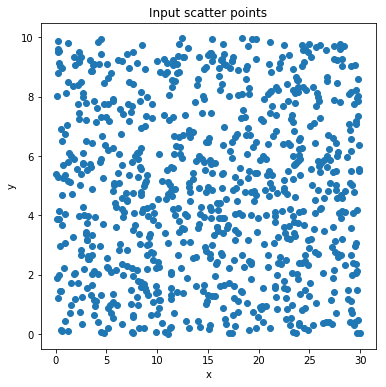

In [43]:
points = []
for z_k in obs_list:
    for point in z_k:
        points.append(point)

points = np.array(points)
plt.figure(figsize=(6,6))
# plt.plot(np.arange(N)*dt,kal,'b')
plt.scatter(points[:, 0], points[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Input scatter points')
plt.show()

show the dynamic process

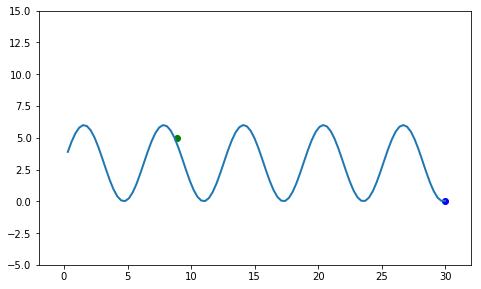

In [31]:
# set up figure and animation
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 32), ylim=(-5, 15))

real_point, = ax.plot([], [], 'bo', ms=6)
rand_point, = ax.plot([], [], 'go', ms=6)
obs_list_anim = np.array(obs_list)
line, = ax.plot([], [], lw=2)

def init():
    """initialize animation"""
    
    real_point.set_data([], [])
    rand_point.set_data([], [])
    line.set_data([], [])
    return real_point, rand_point, line

def animate(i):
    """perform animation step"""
    global dt, ax, fig
    

#     ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
#              / np.diff(ax.get_xbound())[0])

    
    # update pieces of the animation
    
    real_point.set_data(obs_list_anim[i][0][0], obs_list_anim[i][0][1])
    x , y = [], []
    for point in obs_list_anim[i][1:]:
        x.append(point[0])
        y.append(point[1])
    rand_point.set_data(x, y)
    
    line.set_data(3*time_range, 3 + 3 * np.sin(3*time_range))
    return real_point, rand_point

ani = animation.FuncAnimation(fig, animate, frames=len(obs_list),
                              interval=10, blit=True, init_func=init)

ani.save('particle_box.mp4', fps=3)

## 2. Implement the PDA based on our observation data

### 2.1 Setup Kalman Filter

For kalman filter, we have state function

\begin{align}
    x_k &= F_{k-1}x_{k-1} + v_{k-1} \label{eq1} \\
    z_k &= H_kx_k \label{eq2}
\end{align}


The predict step is

\begin{align}
    \hat{x}_{k|k-1} &= F_{k-1}\hat{x}_{k-1|k-1} \label{a} \\
    P_{k|k-1} &= F_{k|k-1}P_{k-1|k-1}F_{k|k-1}^T + Q_{k-1} \label{b} 
\end{align}



The update step is

\begin{align}
    \tilde{z}_k &= z_k - H_{k-1}\hat{x}_{k|k-1} \label{c} \\
    S_k &= H_kP_{k|k-1}H_k^T + R_k \label{d} \\
    K_k &= P_{k|k-1}H_kS_k^{-1} \label{e} \\
    \hat{x}_{k|k} &= \hat{x}_{k|k-1} + K_k\tilde{z}_k \label{f} \\
    P_{k|k} &= (I - K_kH_k)P_{k|k-1} \label{ge} 
\end{align}


In [44]:
class EKFcontrol():
    # here actually a standard Linear KF is implemented 
    def __init__(self, _F,_H,_x,_P,_Q,_R):
        
        self.F=_F
        self.H=_H
        
        self.x_k_k_min=_x
        self.P_k_k_min=_P
        self.Q=_Q
        self.R=_R
        
        self.x_k_k=_x
        self.P_k_k=_P
        
        self.x_dim = _x.shape[0]
        self.z_dim = _H.shape[1]
        
        self.S_k = self.R
    
    def getCurrentState(self):
        return self.x_k_k_min
    
    def getEst(self):
        return np.dot(self.H, self.x_k_k)
    
    def predict(self):
        self.x_k_k_min = np.dot(self.F, self.x_k_k)
        self.P_k_k_min = np.dot(self.F, np.dot(self.P_k_k,self.F.T)) + self.Q
        
    def update(self,z):
        z = np.matrix(z).T

        self.z_bar = np.dot(self.H, self.x_k_k_min)
        self.z_res = z - self.z_bar
        self.S_k = np.dot(np.dot(self.H, self.P_k_k_min), self.H.T) + self.R
        K_k = np.dot(self.P_k_k_min, self.H.T) * inv(self.S_k)
        self.x_k_k = self.x_k_k_min + np.dot (K_k, self.z_res)
        self.P_k_k = np.dot(np.eye(self.x_dim) - np.dot(K_k, self.H), self.P_k_k_min)

def lambda_c(z_k):
    N = len(z_k)   # pda
    V = 300   # volume of obs region
    return N / V

def normalize(a_list):
    the_sum = sum(a_list)
    a_list = a_list / the_sum
    return a_list

## 2.2 Implement PDA Algorithm

In [45]:
# define parameter for our PDA
P_D = 0.9

x0 = np.matrix([0, 3, 0, 0]).T #[x, y, vx, vy]


F = np.matrix([[1, 0, dt, 0],
                [0, 1, 0, dt],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

# kf.B=np.array([[1]])
H=np.matrix([[1, 0, 0, 0],
                [0, 1, 0, 0]])

Q=np.diag([0.2, 0.2, 0.2, 0.2])
R=np.diag([0.2, 0.2])
P = Q
kf = EKFcontrol(F, H, x0, P, Q, R)

pda_est = []
kf.predict()
for z_k in obs_list:
    temp_obs_index = range(len(z_k) + 1)
    weights = []
    x_k = []
    P_k = []
    
    lambda_ = lambda_c(z_k)
    
    for i in temp_obs_index:

        if i == 0:
            weights.append((1 - P_D)*lambda_)
            x_k.append(kf.x_k_k)
            P_k.append(kf.P_k_k)
        else:
            z = np.array(z_k[i-1]).T

            # update the kf
            temp_kf = copy.deepcopy(kf)

            temp_kf.update(z)
            var = multivariate_normal(mean=np.squeeze(temp_kf.z_bar.reshape(2).tolist()[0]), cov=temp_kf.S_k)
            w = P_D * var.pdf(z)
            weights.append(w)
            x_k.append(temp_kf.x_k_k)
            P_k.append(temp_kf.P_k_k)

    norm_weights = normalize(weights)

    x_k_pda = 0 * temp_kf.x_k_k
    P_k_pda = 0 * temp_kf.P_k_k
    for j in range(len(norm_weights)):
        x_k_pda += norm_weights[j] * x_k[j]

    for j in range(len(norm_weights)):
        P_k_pda += norm_weights[j] * (P_k[j] + np.dot(x_k_pda - x_k[j], x_k_pda.T - x_k[j].T))

    # update this to kf
    kf.x_k_k = x_k_pda
    kf.P_k_k = P_k_pda
    kf.predict()
    pda_est.append(kf.getEst())

Let's plot the figure for the tracking result

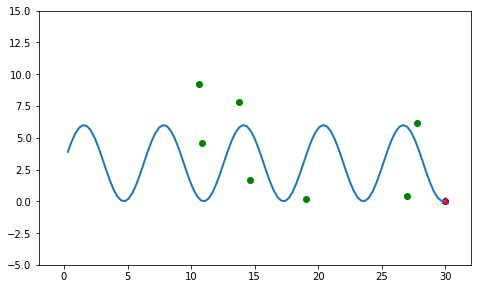

In [46]:
# set up figure and animation
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 32), ylim=(-5, 15))

real_point, = ax.plot([], [], 'bo', ms=6)
rand_point, = ax.plot([], [], 'go', ms=6)
pda_point, = ax.plot([], [], 'r^', ms=6)
obs_list_anim = np.array(obs_list)
line, = ax.plot([], [], lw=2)

def init():
    """initialize animation"""
    
    real_point.set_data([], [])
    rand_point.set_data([], [])
    pda_point.set_data([],[])
    line.set_data([], [])
    return real_point, rand_point, line

def animate(i):
    """perform animation step"""
    global dt, ax, fig
    

#     ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
#              / np.diff(ax.get_xbound())[0])

    
    # update pieces of the animation
    
    real_point.set_data(obs_list_anim[i][0][0], obs_list_anim[i][0][1])
    pda_point.set_data(pda_est[i][0], pda_est[i][1])
    x , y = [], []
    for point in obs_list_anim[i][1:]:
        x.append(point[0])
        y.append(point[1])
    rand_point.set_data(x, y)
    
    line.set_data(3*time_range, 3 + 3 * np.sin(3*time_range))
    return real_point, rand_point

ani = animation.FuncAnimation(fig, animate, frames=len(obs_list),
                              interval=10, blit=True, init_func=init)

ani.save('particle_box_predict.mp4', fps=3)

Here we can see the result is not correct, due to the lack of infomation on the intensity function $\lambda_c(\theta)$, this could change everything after verify with Dr. Lucas W. Krakow